In [14]:
!rm -r images 
!rm -r masks 

rm: cannot remove 'images': No such file or directory
rm: cannot remove 'masks': No such file or directory


# Imports

In [15]:
%%capture

!pip install -q segmentation_models_pytorch

In [16]:
import os
import cv2
import copy
import json
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
from pathlib import Path
import xml.etree.ElementTree as ET


import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import albumentations as A
import segmentation_models_pytorch as smp
from torchsummary import summary

In [17]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

# Config

In [18]:
class CFG:
  model_name       = 'Unet'
  backbone         = 'resnet18'
  img_size         = (512, 512)
  decoder_channels = (256, 128, 64, 32)
  encoder_depth    = 4
  weights          = None
  activation       = None
  in_channels      = 1 
  num_classes      = 1
  n_accumulate     = 1
  train_bs         = 16
  valid_bs         = 16
  n_epoch          = 50
  lr               = 0.001
  device           = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # train_image_dir = "/content/drive/MyDrive/sleap/our_data_train"
  # val_image_dir   = "/content/drive/MyDrive/sleap/our_data_val"
  # train_json_path = "/content/drive/MyDrive/sleap/our_data_train.json"
  # val_json_path   = "/content/drive/MyDrive/sleap/our_data_val.json"
  model_out_dir    = "/content/drive/MyDrive/sleap/"
  video_dir        = Path("/content/drive/MyDrive/mouse_data_labeling")
  annotations_dir  = Path("/content/drive/MyDrive/mouse_data_labeling/annotations")
  videos_name      = ["WIN_20201123_1-1", 
                      # "WIN_20201123_6-3",
                      ]
                    #  "WIN_20201124_mexs2-2-2_trimmed_0-10s", 
                    #  "WIN_20201125_0-4_trimmed_0-10s"]

# Metrics

In [19]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)
        
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # intersection is equivalent to True Positive count
        # union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        iou = (intersection + smooth)/(union + smooth)
        return iou


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)
        
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice


def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice


def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.
    Args:
        labels (np array): Labels.
        y_pred (np array): predictions
    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))
    
    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background


def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.
    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.
    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn


def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.
    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.
    Returns:
        float: mAP.
    """
    truths = np.array(truths.detach().cpu())
    preds = np.array(preds.detach().cpu())
    ious = [compute_iou(np.round(truth, 0), np.round(pred,0)) for truth, pred in zip(truths, preds)]
    
    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

# Datasets

In [20]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, transform, img_size):
      
      videos, images_path, annotations_dict = BuildDataset.process_videos_info()
      BuildDataset.export_frames()
      BuildDataset.export_masks(annotations_dict)

      self.images_path = images_path
      self.transforms = transform
      self.img_size = img_size

    @staticmethod
    def get_mask(cords, frame):
      mask = np.zeros(frame.shape)
      c = {"x":int(cords[0]), "y":int(cords[1])}
      sigma = 30

      for i in range(c["x"]-100, c["x"]+100):
          for j in range(c["y"]-100, c["y"]+100):
              cm_c = np.exp(-((i - c["x"]) ** 2 + (j - c["y"]) ** 2)/ (2 * sigma ** 2))
              if mask[j,i] < cm_c:
                mask[j,i] = cm_c
      return mask
    
    @staticmethod
    def process_videos_info():
      videos = dict()
      images_path = []
      annotations_dict = dict()

      for v in CFG.videos_name:
        # creating videos dict. key: video name value: cv2.VideoCapture
        videos[v] = cv2.VideoCapture(str(CFG.video_dir/(v+".mp4")))

        # accumulating images list. videoname_frameidx
        frame_num = int(videos[v].get(cv2.CAP_PROP_FRAME_COUNT))
        images_path += [f"{v}_{f}.jpg" for f in range(frame_num)]

        # accumulating annotations. key: video_name value: dict(key: body_parths value: dict(key: frame_idx, cords))
        annot_path = CFG.annotations_dir/v/"annotations.xml"
        tree = ET.parse(annot_path)
        root = tree.getroot()

        movie_annot = dict()
        for r in root[2:]:
          points = {}
          for child in r.getchildren():
            points[child.get("frame")+".jpg"] = list(map(int, map(float, child.get("points").split(","))))

          movie_annot[r.get("label")] = points
        
        annotations_dict[v] = movie_annot  
      return videos, images_path, annotations_dict

    @staticmethod
    def get_video_and_frame_name(s):
      underscore_idx = s.rfind('_')
      video_name = s[:underscore_idx]
      frame_name = s[(underscore_idx+1):]
      return video_name, frame_name

    def export_frames(out_dir=Path("images")):
      for video_name in CFG.videos_name:
        frames_path = out_dir/video_name 
        frames_path.mkdir(parents=True, exist_ok=True)

        video = cv2.VideoCapture(str(CFG.video_dir/(video_name+".mp4")))

        frame_idx = 0
        while True:
          success, img = video.read()
          if not success:
              break

          img_path = frames_path/(str(frame_idx)+".jpg")
          cv2.imwrite(str(img_path), img)
          frame_idx += 1

    def export_masks(annotations_dict, out_dir=Path("masks"), frame_dir=Path("images")):
      for video_name, bodyparts in annotations_dict.items():
        (out_dir/video_name).mkdir(parents=True, exist_ok=True)

        for frame_name, cords in tqdm(bodyparts["backbone"].items()):
          frame = cv2.imread(str(frame_dir/video_name/frame_name))
          mask = BuildDataset.get_mask(cords, frame[:,:,0])

          cv2.imwrite(str(out_dir/video_name/frame_name), mask)

    def _get_cords(self, video_name, frame_name):
      return self.annotations_dict[video_name]["nose"][frame_name]
    
    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
      img_name = self.images_path[index]
      video_name, frame_name = BuildDataset.get_video_and_frame_name(img_name)
      img = cv2.imread(f"/content/images/{video_name}/{frame_name}")
      # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      
      # img = img / 255

      mask = cv2.imread(f"/content/masks/{video_name}/{frame_name}")
      # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

      if self.transforms:
          data = self.transforms(image=img, mask=mask)
          img  = data['image']
          msk  = data['mask']
      img, msk = np.expand_dims(img, axis=0), np.expand_dims(msk, axis=0)
      img, msk = torch.tensor(img), torch.tensor(msk)
      
      return img[:,:,:,0], msk[:,:,:,0]


def prepare_loaders():
    print("Video processing....")

    print("*********  Creating datasets  *********")
    train_dataset = BuildDataset(data_transforms["train"], CFG.img_size[0])
    valid_dataset = BuildDataset(data_transforms["valid"], CFG.img_size[0])

    print("********* Creating data loaders *********")
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs,
                              num_workers=2, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.train_bs,
                              num_workers=2, pin_memory=True)
    
    return train_loader, valid_loader

# Training

In [21]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size, running_loss = 0, 0.0
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)
        
        y_pred = model(images)
        loss   = loss_fn(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size

        dice = dice_loss(masks, y_pred).cpu().detach().numpy()
        iou = iou_loss(masks, y_pred).cpu().detach().numpy()
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}', lr=f'{current_lr:0.5f}', dice=f'{dice:0.5f}', iou=f'{iou:0.5f}', gpu_mem=f'{mem:0.2f} GB')
        
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss, dice, iou


def train_one_epoch(model, optimizer, dataloader, device, epoch):
    model.train()
    dataset_size, running_loss = 0, 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:        
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)
        

        # with amp.autocast(enabled=True):
        y_pred = model(images)
        loss   = loss_fn(y_pred, masks)
        loss   = loss / CFG.n_accumulate
            
        loss.backward()
        # if (step + 1) % CFG.n_accumulate == 0:
        optimizer.step()
        optimizer.zero_grad()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size

        dice = dice_loss(masks, y_pred).cpu().detach().numpy()
        iou = iou_loss(masks, y_pred).cpu().detach().numpy()
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}', lr=f'{current_lr:0.5f}', dice=f'{dice:0.5f}', iou=f'{iou:0.5f}', gpu_mem=f'{mem:0.2f} GB')
        
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss


def run_training(model, optimizer, device, num_epochs):
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    best_model = copy.deepcopy(model.state_dict())
    best_dice  = -np.inf
    best_iou   = -np.inf
    best_epoch = -1

    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}')
        train_loss = train_one_epoch(model, optimizer, train_loader, CFG.device, epoch)
        val_loss, val_dice, val_iou = valid_one_epoch(model, valid_loader, CFG.device, epoch)

        if (val_dice >= best_dice) and (val_iou >= best_iou):
            print(f"Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})  ({best_iou:0.4f} ---> {val_iou:0.4f})")
            best_dice  = val_dice
            best_iou   = val_iou
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"{CFG.model_out_dir}best_model.bin")
            print("Model Saved")
        
    print(f"Best score  dice: {best_dice:0.4f}  iou: {best_iou:0.4f}")
    model.load_state_dict(best_model)

    return model

# Model

In [22]:
class DoubleConv(nn.Module):
    """
        Double Convolution layer with both 2 BN and Activation Layer in between
        Conv2d==>BN==>Activation==>Conv2d==>BN==>Activation
    """

    def __init__(self, in_channel, out_channel):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            # nn.BatchNorm2d(out_channel),
            nn.Conv2d(out_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            # nn.BatchNorm2d(out_channel)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class DownConv(nn.Module):
    """
      A maxpool layer followed by a Double Convolution.
      MaxPool2d==>double_conv.
    """

    def __init__(self, in_channel, out_channel):
        super(DownConv, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channel, out_channel)
        )

    def forward(self, x):
        x = self.down(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.activation = nn.ReLU(inplace=True)
        self.double_conv = DoubleConv(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.activation(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.double_conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()

        # DownSampling Block
        self.down_block1 = DoubleConv(in_channel, 16)
        self.down_block2 = DownConv(16, 32)
        self.down_block3 = DownConv(32, 64)
        self.down_block4 = DownConv(64, 128)
        self.down_block5 = DownConv(128, 256)

        # # UpSampling Block
        self.up_block1 = UpSample(256, 128)
        self.up_block2 = UpSample(128, 64)
        self.up_block3 = UpSample(64, 32)
        self.up_block4 = UpSample(32, 16)
        self.up_block5 = nn.Conv2d(16, out_channel, 1)

    def forward(self, x):
        # Down
        x1 = self.down_block1(x)
        x2 = self.down_block2(x1)
        x3 = self.down_block3(x2)
        x4 = self.down_block4(x3)
        x5 = self.down_block5(x4)

        # # Up
        x6 = self.up_block1(x5, x4)
        x7 = self.up_block2(x6, x3)
        x8 = self.up_block3(x7, x2)
        x9 = self.up_block4(x8, x1)
        x10 = self.up_block5(x9)
        return x10


def build_model(my_model=True):
  if my_model:
    model = UNet(1,1)
  else:
    model = getattr(smp, CFG.model_name)(
        encoder_name=CFG.backbone,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=CFG.weights,  # use `imagenet` pre-trained weights for encoder initialization
        in_channels=CFG.in_channels,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,      # model output channels (number of classes in your dataset)
        decoder_channels=CFG.decoder_channels, # List of integers which specify in_channels parameter for convolutions used in decoder.
        encoder_depth=CFG.encoder_depth,       # A number of stages used in encoder. Each stage generate features two times smaller in spatial dimensions than previous one
        activation=CFG.activation,             # An activation function to apply after the final convolution layer
        )
    
  model.to(CFG.device)
  return model


def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# Pipeline

In [23]:
set_seed()

In [24]:
data_transforms = {
    "train": A.Compose([
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
                        A.Normalize()
                        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.Normalize()
        ], p=1.0)
}

In [25]:
train_loader, valid_loader = prepare_loaders()

imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

Video processing....
*********  Creating datasets  *********


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
100%|██████████| 232/232 [00:29<00:00,  7.99it/s]

********* Creating data loaders *********


(torch.Size([16, 1, 512, 512]), torch.Size([16, 1, 512, 512]))

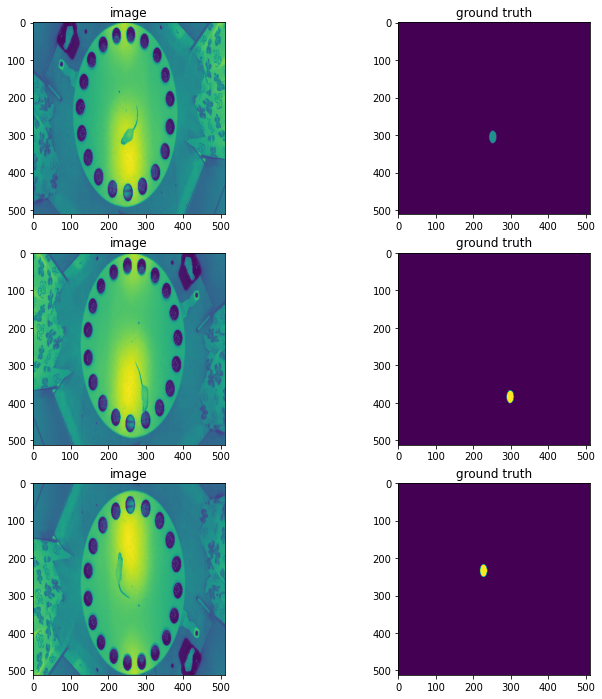

In [26]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 6, 2):
    ax1 = fig.add_subplot(3, 2, i)
    ax1.imshow(imgs[i][0])
    ax1.set_title("image")

    ax2 = fig.add_subplot(3, 2, i+1)
    ax2.imshow(msks[i][0])
    ax2.set_title("ground truth")

In [27]:
loss_fn = nn.MSELoss()
dice_loss = dice_coef
iou_loss  = iou_coef

In [28]:
model_pytorch = build_model()
# model_pytorch = load_model("/content/drive/MyDrive/sleap/model.bin")

train_loader, valid_loader = prepare_loaders()
optimizer = optim.Adam(model_pytorch.parameters(), lr=CFG.lr)

Video processing....
*********  Creating datasets  *********


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
100%|██████████| 232/232 [00:28<00:00,  8.05it/s]

********* Creating data loaders *********


# Run Training

In [29]:
model_pytorch = run_training(model_pytorch, optimizer, device=CFG.device, num_epochs=CFG.n_epoch)

cuda: Tesla T4

Epoch 1/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (-inf ---> 0.0000)  (-inf ---> 0.0000)
Model Saved
Epoch 2/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 3/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.55it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 4/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 5/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 6/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 7/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 8/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.55it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 9/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 10/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0018]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 11/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 12/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0018]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 13/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0019]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 14/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.00000, gpu_mem=2.96 GB, iou=0.00000, lr=0.00100, valid_loss=0.0017]


Valid Score Improved (0.0000 ---> 0.0000)  (0.0000 ---> 0.0000)
Model Saved
Epoch 15/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, dice=0.25206, gpu_mem=2.96 GB, iou=0.14462, lr=0.00100, valid_loss=0.0014]


Valid Score Improved (0.0000 ---> 0.2521)  (0.0000 ---> 0.1446)
Model Saved
Epoch 16/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.57it/s, dice=0.57743, gpu_mem=2.96 GB, iou=0.40603, lr=0.00100, valid_loss=0.0011]


Valid Score Improved (0.2521 ---> 0.5774)  (0.1446 ---> 0.4060)
Model Saved
Epoch 17/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, dice=0.54177, gpu_mem=2.96 GB, iou=0.37163, lr=0.00100, valid_loss=0.0011]


Epoch 18/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.66576, gpu_mem=2.96 GB, iou=0.49918, lr=0.00100, valid_loss=0.0009]


Valid Score Improved (0.5774 ---> 0.6658)  (0.4060 ---> 0.4992)
Model Saved
Epoch 19/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, dice=0.64977, gpu_mem=2.96 GB, iou=0.48141, lr=0.00100, valid_loss=0.0008]


Epoch 20/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.57it/s, dice=0.61269, gpu_mem=2.96 GB, iou=0.44172, lr=0.00100, valid_loss=0.0009]


Epoch 21/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, dice=0.77700, gpu_mem=2.96 GB, iou=0.63566, lr=0.00100, valid_loss=0.0007]


Valid Score Improved (0.6658 ---> 0.7770)  (0.4992 ---> 0.6357)
Model Saved
Epoch 22/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.58it/s, dice=0.74256, gpu_mem=2.96 GB, iou=0.59091, lr=0.00100, valid_loss=0.0007]


Epoch 23/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.58it/s, dice=0.77125, gpu_mem=2.96 GB, iou=0.62794, lr=0.00100, valid_loss=0.0006]


Epoch 24/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, dice=0.87061, gpu_mem=2.96 GB, iou=0.77091, lr=0.00100, valid_loss=0.0005]


Valid Score Improved (0.7770 ---> 0.8706)  (0.6357 ---> 0.7709)
Model Saved
Epoch 25/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.89694, gpu_mem=2.96 GB, iou=0.81315, lr=0.00100, valid_loss=0.0004]


Valid Score Improved (0.8706 ---> 0.8969)  (0.7709 ---> 0.8132)
Model Saved
Epoch 26/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, dice=0.84131, gpu_mem=2.96 GB, iou=0.72626, lr=0.00100, valid_loss=0.0004]


Epoch 27/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, dice=0.89753, gpu_mem=2.96 GB, iou=0.81412, lr=0.00100, valid_loss=0.0005]


Valid Score Improved (0.8969 ---> 0.8975)  (0.8132 ---> 0.8141)
Model Saved
Epoch 28/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.90462, gpu_mem=2.96 GB, iou=0.82599, lr=0.00100, valid_loss=0.0004]


Valid Score Improved (0.8975 ---> 0.9046)  (0.8141 ---> 0.8260)
Model Saved
Epoch 29/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, dice=0.83332, gpu_mem=2.96 GB, iou=0.71433, lr=0.00100, valid_loss=0.0004]


Epoch 30/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, dice=0.90045, gpu_mem=2.96 GB, iou=0.81897, lr=0.00100, valid_loss=0.0004]


Epoch 31/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.89764, gpu_mem=2.96 GB, iou=0.81447, lr=0.00100, valid_loss=0.0004]


Epoch 32/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, dice=0.92480, gpu_mem=2.96 GB, iou=0.86015, lr=0.00100, valid_loss=0.0003]


Valid Score Improved (0.9046 ---> 0.9248)  (0.8260 ---> 0.8602)
Model Saved
Epoch 33/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.91422, gpu_mem=2.96 GB, iou=0.84201, lr=0.00100, valid_loss=0.0003]


Epoch 34/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, dice=0.91128, gpu_mem=2.96 GB, iou=0.83703, lr=0.00100, valid_loss=0.0003]


Epoch 35/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.91601, gpu_mem=2.96 GB, iou=0.84510, lr=0.00100, valid_loss=0.0003]


Epoch 36/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.94279, gpu_mem=2.96 GB, iou=0.89180, lr=0.00100, valid_loss=0.0003]


Valid Score Improved (0.9248 ---> 0.9428)  (0.8602 ---> 0.8918)
Model Saved
Epoch 37/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.51it/s, dice=0.91212, gpu_mem=2.96 GB, iou=0.83849, lr=0.00100, valid_loss=0.0003]


Epoch 38/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, dice=0.86999, gpu_mem=2.96 GB, iou=0.77051, lr=0.00100, valid_loss=0.0007]


Epoch 39/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.91868, gpu_mem=2.96 GB, iou=0.84963, lr=0.00100, valid_loss=0.0003]


Epoch 40/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, dice=0.93098, gpu_mem=2.96 GB, iou=0.87103, lr=0.00100, valid_loss=0.0003]


Epoch 41/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.94377, gpu_mem=2.96 GB, iou=0.89375, lr=0.00100, valid_loss=0.0002]


Valid Score Improved (0.9428 ---> 0.9438)  (0.8918 ---> 0.8937)
Model Saved
Epoch 42/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.54it/s, dice=0.94819, gpu_mem=2.96 GB, iou=0.90175, lr=0.00100, valid_loss=0.0002]


Valid Score Improved (0.9438 ---> 0.9482)  (0.8937 ---> 0.9018)
Model Saved
Epoch 43/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, dice=0.97571, gpu_mem=2.96 GB, iou=0.95264, lr=0.00100, valid_loss=0.0002]


Valid Score Improved (0.9482 ---> 0.9757)  (0.9018 ---> 0.9526)
Model Saved
Epoch 44/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.94664, gpu_mem=2.96 GB, iou=0.89874, lr=0.00100, valid_loss=0.0002]


Epoch 45/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, dice=0.94808, gpu_mem=2.96 GB, iou=0.90132, lr=0.00100, valid_loss=0.0002]


Epoch 46/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, dice=0.93211, gpu_mem=2.96 GB, iou=0.87293, lr=0.00100, valid_loss=0.0002]


Epoch 47/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.54it/s, dice=0.94749, gpu_mem=2.96 GB, iou=0.90038, lr=0.00100, valid_loss=0.0003]


Epoch 48/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, dice=0.94056, gpu_mem=2.96 GB, iou=0.88781, lr=0.00100, valid_loss=0.0002]


Epoch 49/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.59it/s, dice=0.95935, gpu_mem=2.96 GB, iou=0.92203, lr=0.00100, valid_loss=0.0002]


Epoch 50/50


Valid : 100%|██████████| 15/15 [00:09<00:00,  1.58it/s, dice=0.96078, gpu_mem=2.96 GB, iou=0.92454, lr=0.00100, valid_loss=0.0002]


Best score  dice: 0.9757  iou: 0.9526


# Result

In [30]:
test_dataset = BuildDataset(data_transforms["valid"], CFG.img_size[0])
test_loader = DataLoader(test_dataset, batch_size=3, num_workers=2, pin_memory=True)

imgs, msks = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
with torch.no_grad():
    pred = model_pytorch(imgs)
preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
100%|██████████| 232/232 [00:28<00:00,  8.26it/s]


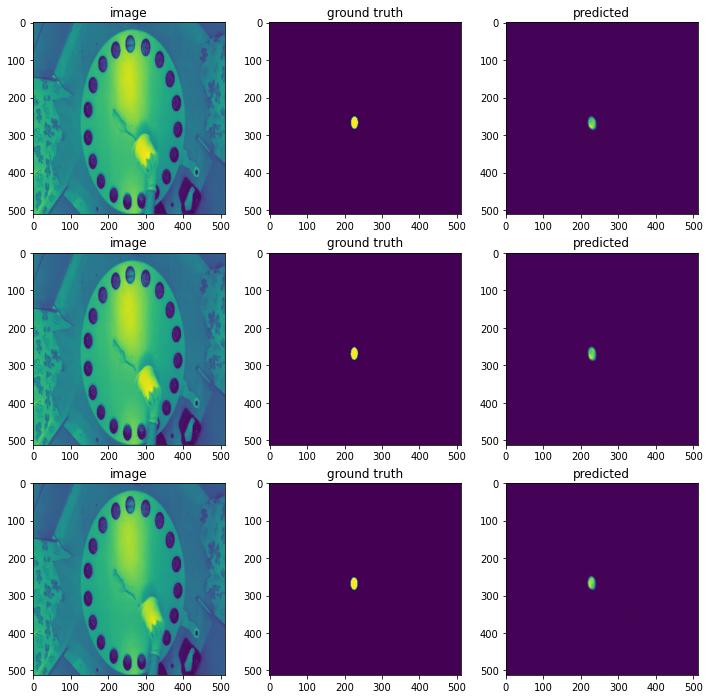

In [31]:
i = 1
fig = plt.figure(figsize=(12, 12))
for img, msk, pred in zip(imgs, msks, preds):
    ax1 = fig.add_subplot(3, 3, i)
    ax1.imshow(img[0])
    ax1.set_title("image")

    ax2 = fig.add_subplot(3, 3, i+1)
    ax2.imshow(msk[0])
    ax2.set_title("ground truth")

    ax3 = fig.add_subplot(3, 3, i+2)
    ax3.imshow(pred[0])
    ax3.set_title("predicted")
    i+= 3